# Demo of MultiStageLikelihood with plain SVGP model

We demonstrate a MultiStageLikelihood driven by a multi-output SVGP model. We fit the model to samples from the
MultiStageLikelihood given toy functions from a Gaussian process draw.


In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from gpflow import set_trainable
from gpflow.ci_utils import ci_niter
from matplotlib import pyplot as plt

2022-01-12 12:56:47.124039: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 12:56:47.124081: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
import markovflow.kernels as mfk
from markovflow.models.sparse_variational import SparseVariationalGaussianProcess as SVGP
from markovflow.ssm_natgrad import SSMNaturalGradient
from markovflow.likelihoods.mutlistage_likelihood import MultiStageLikelihood

## Generate artificial data

We draw toy functions for the three likelihood parameters from a Gaussian process.

In [3]:
N = 100  # number of training points
X_train = np.arange(N).astype(float)
L = 3  # number of latent functions

2022-01-12 12:56:49.407305: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-12 12:56:49.407623: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-01-12 12:56:49.407641: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-12 12:56:49.407666: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az90-583): /proc/driver/nvidia/version does not exist
2022-01-12 12:56:49.408008: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FM

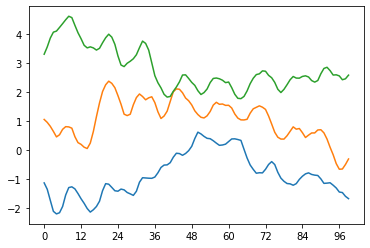

In [4]:
# Define the kernel
k1a = gpflow.kernels.Periodic(
    gpflow.kernels.Matern52(variance=1.0, lengthscales=3.0), period=12.0
)
k1b = gpflow.kernels.Matern52(variance=1.0, lengthscales=30.0)
k2 = gpflow.kernels.Matern32(variance=0.1, lengthscales=5.0)
k = k1a * k1b + k2

# Draw three independent functions from the same Gaussian process
X = X_train
num_latent = L
K = k(X[:, None])
np.random.seed(123)
v = np.random.randn(len(K), num_latent)
# We draw samples from a GP with kernel k(.) evaluated at X by reparameterizing:
# f ~ N(0, K) → f = chol(K) v, v ~ N(0, I), where chol(K) chol(K)ᵀ = K
f = np.linalg.cholesky(K + 1e-6 * np.eye(len(K))) @ v

# We shift the third function to increase the mean of the Poisson component to 20 to make it easier to identify
f += np.array([0.0, 0.0, np.log(20)]).reshape(1, L)

# Plot all three functions
plt.figure()
for i in range(num_latent):
    plt.plot(X, f[:, i])
_ = plt.xticks(np.arange(0, 100, 12))

The above latent GPs represent how the three likelihood parameters will change over time.

In [5]:
# Define the likelihood
lik = MultiStageLikelihood()
# Draw observations from the likelihood given the functions `f` from the previous step
Y = lik.sample_y(tf.convert_to_tensor(f, dtype=gpflow.default_float()))

2022-01-12 12:56:49.801559: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-12 12:56:49.804614: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2095074999 Hz


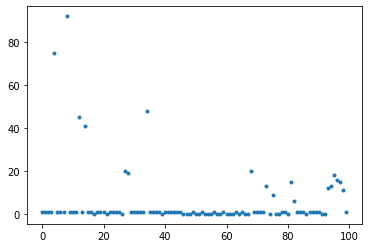

In [6]:
# Plot the observations
_ = plt.plot(X, Y, ".")

In [7]:
Y_train = Y
data = (X_train, Y_train)

## Create the model
(Note: as we are replicating the modelling task, we pretend we don't know the underlying processes that created the artificial data.)

We decide to create 3 GPs each with an independent Matern kernel, as we need three functions to drive the three parameters of the likelihood.
This will correspond to learning 6 hyperparameters (3 GPs with 2 hyper-parameters each).

In [8]:
# Create kernels
kern_list = [mfk.Matern32(variance=1.0, lengthscale=10.0, jitter=1e-6) for _ in range(L)]

In [9]:
# Create multi-output kernel from kernel list
ker = mfk.IndependentMultiOutput(kern_list)

In [10]:
# Create evenly spaced inducing points
num_inducing = N // 10
Z = np.linspace(X_train.min(), X_train.max(), num_inducing)

In [11]:
# create multi-output inducing variables from Z
inducing_variable = tf.constant(Z)

In [12]:
likelihood = MultiStageLikelihood()

In [13]:
model = SVGP(
    kernel=ker, likelihood=likelihood, inducing_points=inducing_variable, mean_function=None,
)

Instructions for updating:
Do not call `graph_parents`.


In [14]:
X_grid = X

## Optimise the model

NatGrads and Adam for SVGP

In [15]:
adam_learning_rate = 0.001
natgrad_learning_rate = 0.05

In [16]:
adam_opt = tf.optimizers.Adam(learning_rate=adam_learning_rate)
natgrad_opt = SSMNaturalGradient(gamma=natgrad_learning_rate, momentum=False)

# Stop Adam from optimizing the variational parameters

set_trainable(model.dist_q, False)
adam_var_list = model.trainable_variables
set_trainable(model.dist_q, True)

2022-01-12 12:56:50.169739: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


We separate the training process into hyper-parameters and variational parameters, which in practice, can result in better training.

For the variational parameters we can use much larger step sizes using natural gradients (whereas the hyper-parameters
take smaller steps using Adam).

This results in optimisation being more efficient (i.e. faster and better results).

In [17]:
# Variables optimized by the Adam optimizer:
print(adam_var_list)

(<tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>, <tf.Variable 'lengthscale:0' shape=() dtype=float64, numpy=9.99995459903963>, <tf.Variable 'variance:0' shape=() dtype=float64, numpy=0.5413248546129181>)


In [18]:
@tf.function
def model_loss():
    return -model.elbo(data)

In [19]:
print(model_loss().numpy())

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


1406.0687187245856


In [20]:
@tf.function
def step():

    # first take step with hyper-parameters with Adam
    adam_opt.minimize(model_loss, var_list=adam_var_list)
    # then variational parameters with NatGrad
    natgrad_opt.minimize(model_loss, model.dist_q)

In [21]:
@tf.function
def sample_y(X, num_samples, correlated: bool = False):
    if correlated:
        # this path may give Cholesky errors
        f_samples = model.posterior.sample_f(X, num_samples)
    else:
        f_mean, f_var = model.posterior.predict_f(X)
        f_samples = tfp.distributions.Normal(f_mean, tf.sqrt(f_var)).sample(num_samples)
    return likelihood.sample_y(f_samples)

In [22]:
# the arguments to a tf.function-wrapped function need to be Tensors, not numpy arrays:
X_grid_tensor = tf.convert_to_tensor(X_grid)

0 tf.Tensor(13691.716352019374, shape=(), dtype=float64)
1 tf.Tensor(3034.7541944494264, shape=(), dtype=float64)
2 tf.Tensor(2408.590870500121, shape=(), dtype=float64)
3 tf.Tensor(2035.3778465533226, shape=(), dtype=float64)
4 tf.Tensor(1779.9410351114198, shape=(), dtype=float64)
5 tf.Tensor(1590.751847396182, shape=(), dtype=float64)
6 tf.Tensor(1443.236273058319, shape=(), dtype=float64)
7 tf.Tensor(1323.9726728731337, shape=(), dtype=float64)
8 tf.Tensor(1224.9218930830054, shape=(), dtype=float64)
9 tf.Tensor(1140.933605827706, shape=(), dtype=float64)
10 tf.Tensor(1068.5341895851543, shape=(), dtype=float64)
11 tf.Tensor(1005.2837327678849, shape=(), dtype=float64)
12 tf.Tensor(949.4109874714991, shape=(), dtype=float64)
13 tf.Tensor(899.5945381701872, shape=(), dtype=float64)
14 tf.Tensor(854.8256310956359, shape=(), dtype=float64)


15 tf.Tensor(814.3189188943696, shape=(), dtype=float64)
16 tf.Tensor(777.4525105540206, shape=(), dtype=float64)
17 tf.Tensor(743.7265898044494, shape=(), dtype=float64)
18 tf.Tensor(712.734163742803, shape=(), dtype=float64)
19 tf.Tensor(684.1399497818634, shape=(), dtype=float64)
20 tf.Tensor(657.6648523621715, shape=(), dtype=float64)
21 tf.Tensor(633.074359786628, shape=(), dtype=float64)
22 tf.Tensor(610.1697419287182, shape=(), dtype=float64)
23 tf.Tensor(588.7812829305042, shape=(), dtype=float64)
24 tf.Tensor(568.7630150044663, shape=(), dtype=float64)
25 tf.Tensor(549.9885748759187, shape=(), dtype=float64)
26 tf.Tensor(532.3479104479607, shape=(), dtype=float64)
27 tf.Tensor(515.744638844455, shape=(), dtype=float64)
28 tf.Tensor(500.093908816111, shape=(), dtype=float64)


29 tf.Tensor(485.32065752332676, shape=(), dtype=float64)
30 tf.Tensor(471.35817850781484, shape=(), dtype=float64)
31 tf.Tensor(458.1469372933711, shape=(), dtype=float64)
32 tf.Tensor(445.6335855931509, shape=(), dtype=float64)
33 tf.Tensor(433.7701359790452, shape=(), dtype=float64)
34 tf.Tensor(422.51326708794244, shape=(), dtype=float64)
35 tf.Tensor(411.82373570580523, shape=(), dtype=float64)
36 tf.Tensor(401.66587688841884, shape=(), dtype=float64)
37 tf.Tensor(392.0071770115588, shape=(), dtype=float64)
38 tf.Tensor(382.81790755882236, shape=(), dtype=float64)
39 tf.Tensor(374.07080974800743, shape=(), dtype=float64)


40 tf.Tensor(365.7408219119054, shape=(), dtype=float64)
41 tf.Tensor(357.8048429953922, shape=(), dtype=float64)
42 tf.Tensor(350.2415266896858, shape=(), dtype=float64)
43 tf.Tensor(343.03110165902825, shape=(), dtype=float64)
44 tf.Tensor(336.15521407245313, shape=(), dtype=float64)
45 tf.Tensor(329.59678927052164, shape=(), dtype=float64)
46 tf.Tensor(323.3399099024287, shape=(), dtype=float64)
47 tf.Tensor(317.36970828490576, shape=(), dtype=float64)
48 tf.Tensor(311.6722710783122, shape=(), dtype=float64)
49 tf.Tensor(306.2345546609396, shape=(), dtype=float64)
50 tf.Tensor(301.04430982076957, shape=(), dtype=float64)
51 tf.Tensor(296.09001458336525, shape=(), dtype=float64)
52 tf.Tensor(291.3608141621924, shape=(), dtype=float64)
53 tf.Tensor(286.8464671590855, shape=(), dtype=float64)
54 tf.Tensor(282.5372972622053, shape=(), dtype=float64)
55 tf.Tensor(278.4241497904791, shape=(), dtype=float64)


56 tf.Tensor(274.4983525200224, shape=(), dtype=float64)
57 tf.Tensor(270.75168030195243, shape=(), dtype=float64)
58 tf.Tensor(267.17632304426, shape=(), dtype=float64)
59 tf.Tensor(263.76485668474925, shape=(), dtype=float64)
60 tf.Tensor(260.51021682875114, shape=(), dtype=float64)
61 tf.Tensor(257.4056747656101, shape=(), dtype=float64)
62 tf.Tensor(254.44481561275654, shape=(), dtype=float64)
63 tf.Tensor(251.62151836627936, shape=(), dtype=float64)
64 tf.Tensor(248.92993766304772, shape=(), dtype=float64)
65 tf.Tensor(246.36448708211213, shape=(), dtype=float64)
66 tf.Tensor(243.9198238328534, shape=(), dtype=float64)
67 tf.Tensor(241.59083469456277, shape=(), dtype=float64)
68 tf.Tensor(239.37262308713628, shape=(), dtype=float64)
69 tf.Tensor(237.2604971657227, shape=(), dtype=float64)


70 tf.Tensor(235.24995884364841, shape=(), dtype=float64)
71 tf.Tensor(233.3366936580384, shape=(), dtype=float64)
72 tf.Tensor(231.51656140143447, shape=(), dtype=float64)
73 tf.Tensor(229.78558745049753, shape=(), dtype=float64)
74 tf.Tensor(228.13995472979474, shape=(), dtype=float64)
75 tf.Tensor(226.57599625473478, shape=(), dtype=float64)
76 tf.Tensor(225.09018820313057, shape=(), dtype=float64)
77 tf.Tensor(223.67914346963434, shape=(), dtype=float64)
78 tf.Tensor(222.33960566154764, shape=(), dtype=float64)
79 tf.Tensor(221.06844349831584, shape=(), dtype=float64)
80 tf.Tensor(219.86264558038084, shape=(), dtype=float64)
81 tf.Tensor(218.7193154961223, shape=(), dtype=float64)
82 tf.Tensor(217.6356672383281, shape=(), dtype=float64)
83 tf.Tensor(216.6090209040936, shape=(), dtype=float64)


84 tf.Tensor(215.63679865425763, shape=(), dtype=float64)
85 tf.Tensor(214.7165209104948, shape=(), dtype=float64)
86 tf.Tensor(213.845802769988, shape=(), dtype=float64)
87 tf.Tensor(213.02235061927195, shape=(), dtype=float64)
88 tf.Tensor(212.2439589303413, shape=(), dtype=float64)
89 tf.Tensor(211.50850722349784, shape=(), dtype=float64)
90 tf.Tensor(210.81395718268197, shape=(), dtype=float64)
91 tf.Tensor(210.15834991019983, shape=(), dtype=float64)
92 tf.Tensor(209.5398033088302, shape=(), dtype=float64)
93 tf.Tensor(208.9565095802983, shape=(), dtype=float64)
94 tf.Tensor(208.40673283001743, shape=(), dtype=float64)
95 tf.Tensor(207.8888067688676, shape=(), dtype=float64)
96 tf.Tensor(207.401132503573, shape=(), dtype=float64)
97 tf.Tensor(206.94217640798811, shape=(), dtype=float64)
98 tf.Tensor(206.51046806829828, shape=(), dtype=float64)


99 tf.Tensor(206.10459829579378, shape=(), dtype=float64)


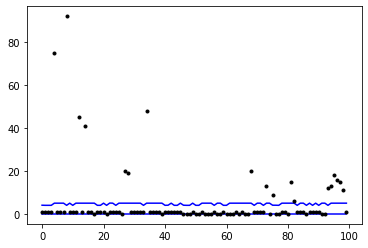

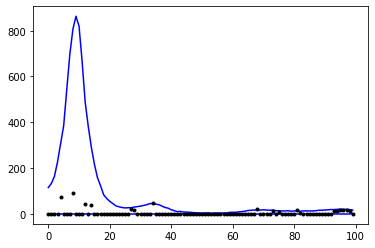

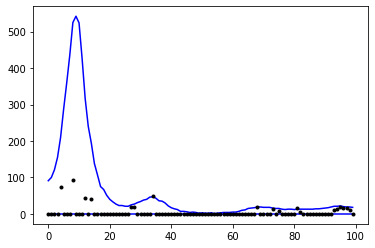

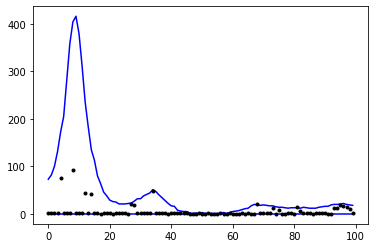

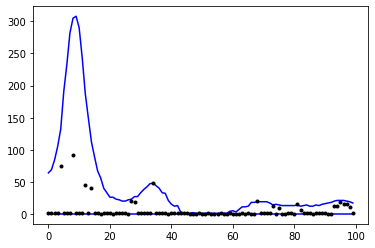

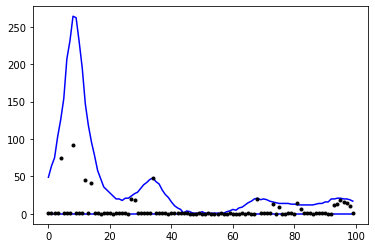

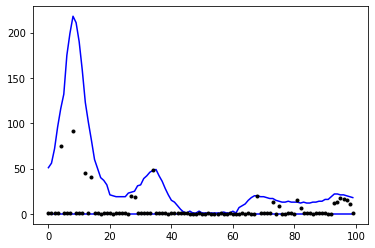

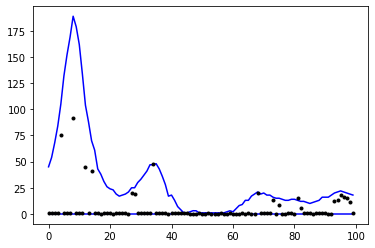

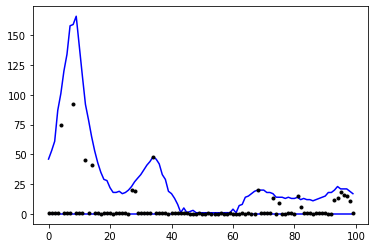

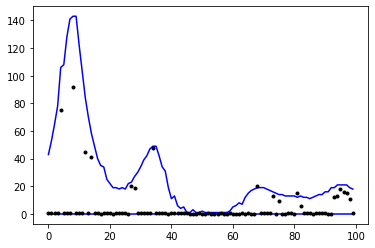

In [23]:
iterations = ci_niter(100)

# run the optimization
for it in range(iterations):
    if it % 10 == 0:

        plt.figure()
        y_samples = sample_y(X_grid_tensor, 1000)
        lower, upper = np.quantile(y_samples, q=[0.05, 0.95], axis=0).squeeze(-1)
        plt.plot(X_grid, lower, "b-")
        plt.plot(X_grid, upper, "b-")
        # f_samples = model.posterior.sample_f(X_grid, 10)
        # plt.plot(X_grid, f_samples[..., 0].numpy().T, 'b-')
        plt.plot(X_train, Y_train, "k.")
        # plt.savefig("test_%03d.png" % it)
        # plt.close()

    step()
    print(it, model_loss())

## Compare inferred functions with ground truth

In [24]:
Fmean, Fvar = model.predict_f(X_grid)

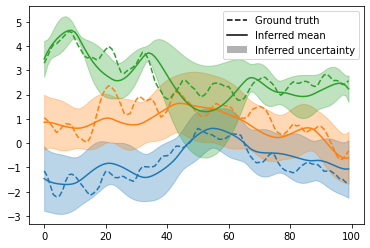

In [25]:
for i in range(num_latent):
    plt.plot(X_grid, Fmean[:, i], f"C{i}-")
    plt.fill_between(
        X_grid,
        Fmean[:, i] - 2 * tf.sqrt(Fvar[:, i]),
        Fmean[:, i] + 2 * tf.sqrt(Fvar[:, i]),
        color=f"C{i}",
        alpha=0.3,
    )

    plt.plot(X, f[:, i], f"C{i}--")

# Custom legend:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.legend(
    loc="upper right",
    handles=[
        Line2D([0], [0], color="k", ls="--", label="Ground truth"),
        Line2D([0], [0], color="k", label="Inferred mean"),
        Patch(facecolor="k", alpha=0.3, label="Inferred uncertainty"),
    ],
)

The above plot shows that our linear combination of GPs with Matern kernels has done a reasonable job of representing the ground truth.